Food-101 Data Pipeline
---------------------
This notebook creates TensorFlow datasets for training the food recognition model.


In [8]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from tqdm import tqdm

# Load Food-101 dataframe
food101_df = pd.read_pickle("../data/food101_df.pkl")
print(f"Loaded dataset with {len(food101_df)} images")

# Define constants
IMG_SIZE = 224  # Standard input size for MobileNet models
BATCH_SIZE = 32  # Adjust based on your GPU memory
AUTOTUNE = tf.data.AUTOTUNE  # Optimize loading performance

Loaded dataset with 101000 images


In [9]:
# Split the data
train_df = food101_df[food101_df['split'] == 'train']
test_df = food101_df[food101_df['split'] == 'test']

print(f"Training set: {len(train_df)} images")
print(f"Test set: {len(test_df)} images")

Training set: 75750 images
Test set: 25250 images


In [10]:
# Create label mapping (for numerical indices)
labels = sorted(food101_df['label'].unique())
label_to_index = {label: i for i, label in enumerate(labels)}
index_to_label = {i: label for label, i in label_to_index.items()}

# Save label mappings
with open('food101_label_mappings.json', 'w') as f:
    json.dump({'label_to_index': label_to_index, 'index_to_label': index_to_label}, f)

print(f"Created label mappings for {len(labels)} classes")

Created label mappings for 101 classes


In [11]:
# Function to load and preprocess images
def preprocess_image(image_path):
    """Load and preprocess a single image."""
    # Read image file
    image = tf.io.read_file(image_path)
    # Decode JPEG
    image = tf.image.decode_jpeg(image, channels=3)
    # Resize
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    # Normalize pixel values
    image = tf.cast(image, tf.float32) / 255.0
    return image

# Function to load and preprocess a batch of images
def process_path(image_path, label):
    """Process a single data point."""
    image = preprocess_image(image_path)
    return image, label

# Data augmentation function
def augment(image, label):
    """Apply random augmentations to training images."""
    # Random flip
    image = tf.image.random_flip_left_right(image)
    # Random brightness
    image = tf.image.random_brightness(image, max_delta=0.2)
    # Random contrast
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    # Random hue
    image = tf.image.random_hue(image, max_delta=0.1)
    # Ensure pixel values remain in [0,1]
    image = tf.clip_by_value(image, 0.0, 1.0)
    return image, label

# Function to create a TensorFlow dataset
def create_dataset(df, augment_data=False):
    """Create a TensorFlow dataset from a dataframe."""
    # Convert string paths to TensorFlow string tensors
    image_paths = tf.convert_to_tensor(df['image_path'].values)
    # Convert labels to indices
    labels = tf.convert_to_tensor([label_to_index[label] for label in df['label'].values])
    
    # Create a dataset of paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    
    # Process images
    dataset = dataset.map(lambda x, y: (preprocess_image(x), y), 
                         num_parallel_calls=AUTOTUNE)
    
    # Apply augmentation to training data
    if augment_data:
        dataset = dataset.map(augment, num_parallel_calls=AUTOTUNE)
    
    # Batch and prefetch for performance
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    
    return dataset


In [12]:
# Create datasets
print("Creating training dataset with augmentation...")
train_dataset = create_dataset(train_df, augment_data=True)

print("Creating test dataset...")
test_dataset = create_dataset(test_df, augment_data=False)

# Check dataset shapes
for images, labels in train_dataset.take(1):
    print(f"Training batch shape: images={images.shape}, labels={labels.shape}")


Creating training dataset with augmentation...
Creating test dataset...
Training batch shape: images=(32, 224, 224, 3), labels=(32,)


2025-03-17 19:02:27.465754: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2025-03-17 19:02:27.912105: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


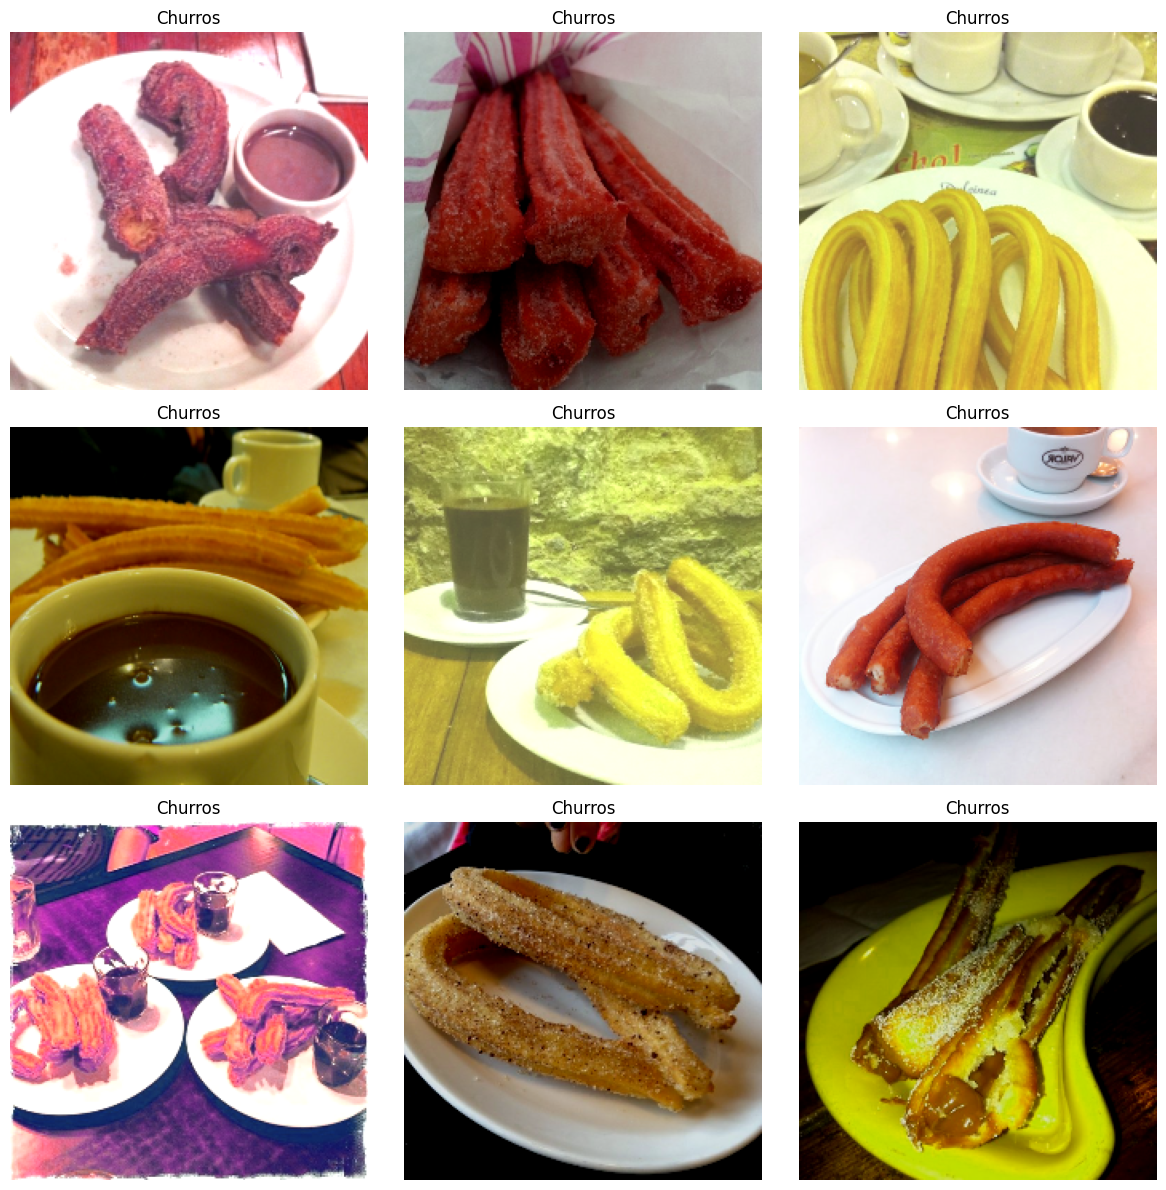

In [13]:
# Visualize a batch of training images
plt.figure(figsize=(12, 12))
for images, labels in train_dataset.take(1):
    for i in range(min(9, BATCH_SIZE)):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title(index_to_label[labels[i].numpy()].replace('_', ' ').title())
        plt.axis('off')
plt.tight_layout()
plt.show()

# Save datasets for reuse
os.makedirs("../tf_datasets", exist_ok=True)

In [14]:
try:
    print("Saving TensorFlow datasets...")
    tf.data.Dataset.save(train_dataset, "../tf_datasets/food101_train")
    tf.data.Dataset.save(test_dataset, "../tf_datasets/food101_test")
    print("Datasets saved successfully!")
except Exception as e:
    print(f"Error saving datasets: {e}")
    print("We'll need to regenerate datasets when training.")

# Verify dataset can be loaded
try:
    print("Testing dataset loading...")
    loaded_dataset = tf.data.experimental.load("../tf_datasets/food101_train")
    for images, labels in loaded_dataset.take(1):
        print(f"Successfully loaded dataset with shape: {images.shape}")
except Exception as e:
    print(f"Could not verify dataset loading: {e}")

print("Data pipeline complete!")

Saving TensorFlow datasets...
Datasets saved successfully!
Testing dataset loading...
Instructions for updating:
Use `tf.data.Dataset.load(...)` instead.
Successfully loaded dataset with shape: (32, 224, 224, 3)
Data pipeline complete!


2025-03-17 19:04:44.927383: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
